# EXAMPLE 2:
In this example we show how one can perturb the initial condition of the KS equation.
This is done to investigate initial condition sensitivity. And demonstrate that one can instanciate two instances of the class for comparison. 

In [ ]:
import os
os.environ["JAX_ENABLE_X64"] = "true"
import sys
sys.path.append('..')
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax import config
config.update("jax_enable_x64", True)

In [6]:
signal_params = ConfigDict(KS_params)
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
signal_model_2 = ETD_KT_CM_JAX_Vectorised(signal_params)
print(signal_model.params)


Advection_basis_name: none
E: 1
Forcing_basis_name: none
P: 0
S: 0
c_0: 0
c_1: 1
c_2: 1
c_3: 0.0
c_4: 1
dt: 0.25
equation_name: Kuramoto-Sivashinsky
initial_condition: Kassam_Trefethen_KS_IC
method: Dealiased_ETDRK4
noise_magnitude: 0.0
nt: 600
nx: 256
tmax: 150.0
xmax: 100.53096491487338
xmin: 0.0



Now we continue to define a stochastic ensemble

Now we specify the models, by calling the class.

In [7]:
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
initial_signal_2 = initial_signal + 1e-8*jnp.asarray(np.random.randn(*initial_signal.shape))
time = jnp.linspace(0, signal_model.params.tmax, signal_model.params.nt)

In [8]:
key = jax.random.PRNGKey(0)
final, all = signal_model.run(initial_signal, signal_model.params.nt,None,key) 
final_2, all_2 = signal_model_2.run(initial_signal_2, signal_model.params.nt,None,key)  

Put in the initial condition.

In [9]:

signal = jnp.concatenate([initial_signal[None,...], all], axis=0)
signal_2 = jnp.concatenate([initial_signal_2[None,...], all_2], axis=0)


Visualise difference 

In [10]:
def plot(time_step):
    plt.figure(figsize=(8, 6))
    plt.plot(signal_model.x, signal[time_step, 0, :], color='k', label='Signal')
    plt.plot(signal_model.x, signal_2[time_step, 0, :], color='r', linestyle='--', label='Perturbed Signal')
    plt.xlabel('Spatial Coordinate (x)', fontsize=14)
    plt.ylabel('Signal Amplitude', fontsize=14)
    plt.title(f'Signal Comparison at Time Step {time_step}', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

interact(plot, time_step=(0, signal_model.params.nt))

interactive(children=(IntSlider(value=300, description='time_step', max=600), Output()), _dom_classes=('widget…

<function __main__.plot(time_step)>

Space time plots of both solutions:

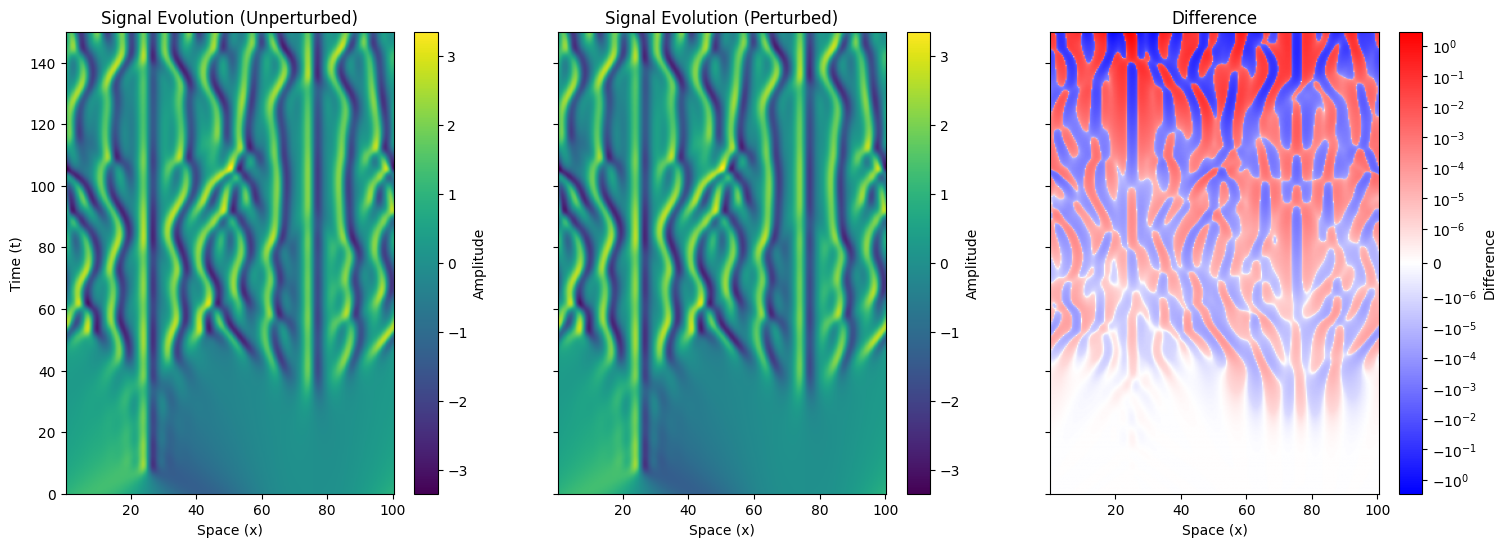

In [14]:
from matplotlib.colors import SymLogNorm


fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

im_a = axs[0].imshow(all[:,0,:], aspect='auto', origin='lower', extent=[signal_model.x[0], signal_model.x[-1], time[0], time[-1]])
axs[0].set_title('Signal Evolution (Unperturbed)')
axs[0].set_xlabel('Space (x)')
axs[0].set_ylabel('Time (t)')
plt.colorbar(im_a, ax=axs[0], label='Amplitude')

im_b = axs[1].imshow(all_2[:,0,:], aspect='auto', origin='lower', extent=[signal_model.x[0], signal_model.x[-1], time[0], time[-1]])
axs[1].set_title('Signal Evolution (Perturbed)')
axs[1].set_xlabel('Space (x)')
plt.colorbar(im_b, ax=axs[1], label='Amplitude')

diff = all[:,0,:] - all_2[:,0,:]
# Use a symmetric log scale to highlight small differences

vmax = jnp.max(jnp.abs(diff))
norm = SymLogNorm(linthresh=1e-6, linscale=1, vmin=-vmax, vmax=vmax, base=10)
im_c = axs[2].imshow(diff, aspect='auto', origin='lower', extent=[signal_model.x[0], signal_model.x[-1], time[0], time[-1]], cmap='bwr', norm=norm)
# im_c = axs[2].imshow(diff, aspect='auto', origin='lower', extent=[signal_model.x[0], signal_model.x[-1], time[0], time[-1]], cmap='bwr')
axs[2].set_title('Difference')
axs[2].set_xlabel('Space (x)')
plt.colorbar(im_c, ax=axs[2], label='Difference')
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/KS_sensitivity.png',bbox_inches='tight',dpi=300)


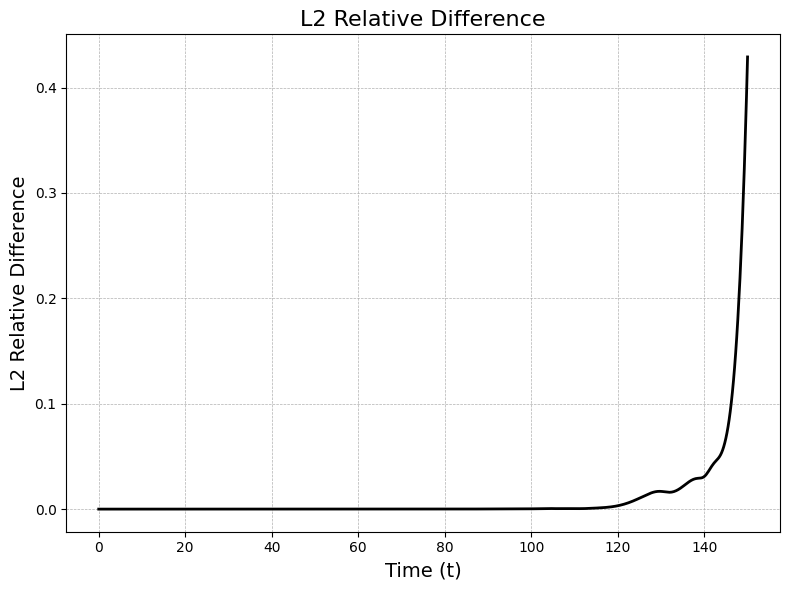

In [15]:
difference = all[:, 0, :] - all_2[:, 0, :]
relative_error = jnp.linalg.norm(difference, axis=-1) / jnp.linalg.norm(all[:, 0, :], axis=-1)

plt.figure(figsize=(8, 6))
plt.plot(time, relative_error, color='k', linewidth=2)
plt.title('L2 Relative Difference', fontsize=16)
plt.xlabel('Time (t)', fontsize=14)
plt.ylabel('L2 Relative Difference', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

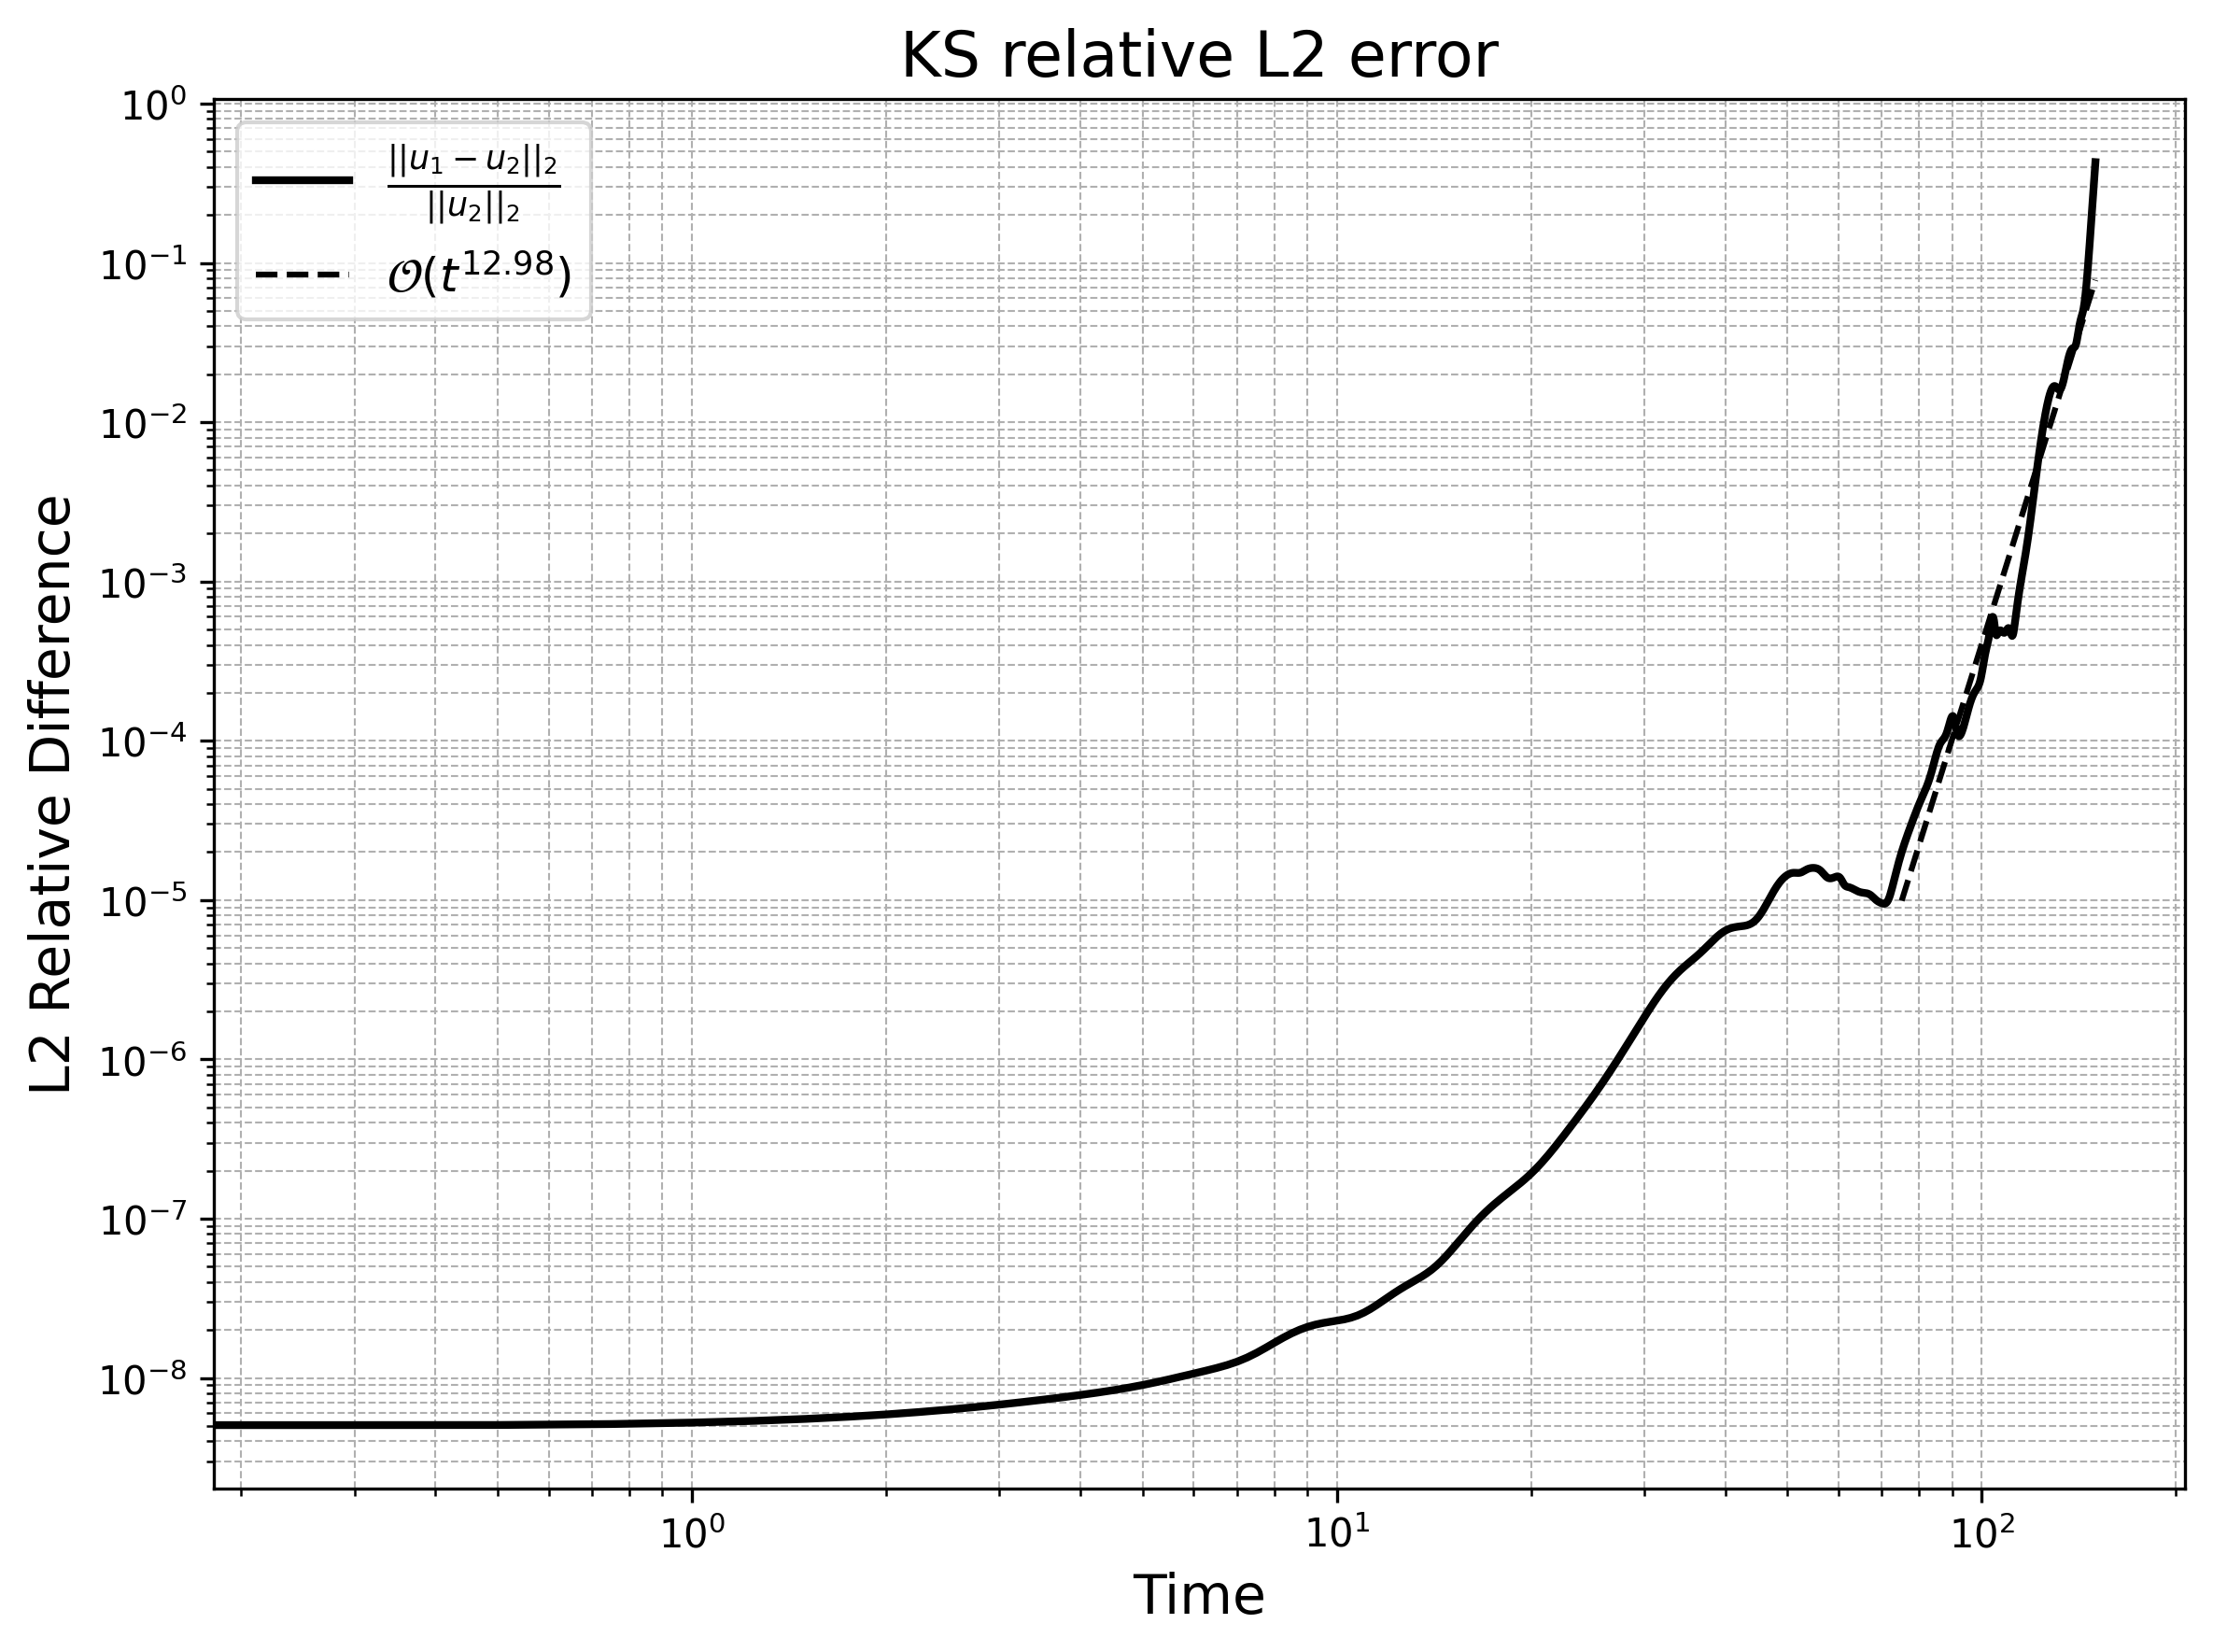

In [26]:
plt.figure(dpi=300,figsize=(8, 6))
plt.title(r'KS relative L2 error', fontsize=16)
plt.loglog(time, relative_error, color='k', linewidth=2, label=r'$\frac{||u_1 - u_2||_{2}}{||u_2||_{2}}$')
# Approximate the gradient (slope) in log-log space for the last 10 points
x_fit = time[-300:]
y_fit = relative_error[-300:]
log_x = jnp.log(x_fit)
log_y = jnp.log(y_fit)
slope, intercept = jnp.polyfit(log_x, log_y, 1)
plt.loglog(x_fit, jnp.exp(intercept) * x_fit**slope, 'k--', label=fr'$\mathcal{{O}}(t^{{{slope:.2f}}})$')
plt.xlabel('Time', fontsize=14)
plt.ylabel('L2 Relative Difference', fontsize=14)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/KS_ic_pertubation_error.png',bbox_inches='tight',dpi=300)
plt.show()

We see that the initial condition pertubation grows by order magnitude $10^8$, and we see in the Log-Log plot, exponential growth. 